In [31]:
import sys
sys.path.append("/scratch/gf332/BayesOpt/boa/scripts")

import os
import logging

import tensorflow as tf
import tensorflow_probability as tfp

from varz.tensorflow import Vars, minimise_l_bfgs_b, minimise_adam
from stheno.tensorflow import GP, EQ, Delta, Graph, Matern52
from stheno.tensorflow import Graph

import numpy as np
import matplotlib.pyplot as plt

from boa.models.random import RandomModel
from boa.models.fully_factorized_gp import FullyFactorizedGPModel
from boa.models.gpar import GPARModel
from boa.models.matrix_factorized_gpar import MatrixFactorizedGPARModel
from boa.models.gpar_perm import PermutedGPARModel

from boa.core.distribution import GumbelMatching

from boa.core.kernel import DiscreteEQ, DiscreteMatern52

from boa.core.gp import GaussianProcess
from boa.core.utils import inv_perm, calculate_euclidean_distance_percentiles

from boa.datasets.loader import load_dataset
from experiments import prepare_gpar_data

from sklearn.model_selection import train_test_split

In [3]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

# Test Independent GP Model vs Reference Implementation

In [3]:
# Target function (noise free).
def f(X):
    return (np.sinc(3 * X) + 0.5 * (X - 0.5)**2).reshape(-1, 1)


# Generate X's and Y's for training.
np.random.seed(42)
X_train = np.array([
    -0.25,
    0,
    0.1,
]).reshape(-1, 1)
Y_train = f(X_train)

x_candidates = np.linspace(-1, 1, 100).reshape([-1, 1])

In [4]:
random_model = RandomModel(input_dim=1, output_dim=1, seed=42, num_samples=10)
random_model = random_model.condition_on(X_train, Y_train)

model_v2 = FullyFactorizedGPModel(kernel='rbf', input_dim=1, output_dim=1, verbose=False)
model_v2.fit(X_train, Y_train, optimizer_restarts=3)
model_v2 = model_v2.condition_on(X_train, Y_train)

INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 1 / 3
INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 4.1566
INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 2 / 3
INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 4.1566
INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 3 / 3
INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 4.1566


INFO:boa.models.fully_factorized_gp:GPs haven't been cached yet, creating them now.


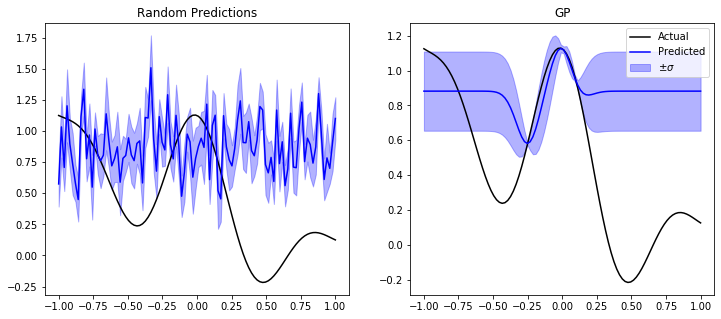

In [5]:
random_mean, random_var = random_model.predict(x_candidates, numpy=True)

pred_mean_v2, pred_var_v2 = model_v2.predict(x_candidates, numpy=True)

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.title("Random Predictions")
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, random_mean, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (random_mean + np.sqrt(random_var)).T[0], (random_mean - np.sqrt(random_var)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.subplot(122)
plt.title("GP")
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, pred_mean_v2, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (pred_mean_v2 + np.sqrt(pred_var_v2)).T[0], (pred_mean_v2 - np.sqrt(pred_var_v2)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.legend()

plt.show()

# Test GP, GPAR and MF-GPAR implementations in 1-D

In [63]:
# Test function
def f(x):
    return np.sinc(3 * x[:, 0]).reshape(-1, 1)

# Set seed for reproducibility
np.random.seed(42)

# Generate input data
x_train = np.random.rand(8, 2) * 2 - 1
pseudo_point = np.array([[0.8, 0.3]])
x_train = np.vstack([x_train, pseudo_point])

y_train = f(x_train)

# Points for plotting
x_cont = np.arange(-1.5, 1.5, 0.02).reshape(-1, 1)
x_cont = np.hstack([x_cont, x_cont])

In [7]:
# FF-GP model
ff_gp = FullyFactorizedGPModel(kernel='rbf', 
                               input_dim=2, 
                               output_dim=1, 
                               verbose=False, 
                               initialization_heuristic="random")

ff_gp.fit(x_train, y_train, optimizer_restarts=5)
ff_gp = ff_gp.condition_on(x_train, y_train)

y_pred_ff_gp, var_pred_ff_gp = ff_gp.predict(x_cont, numpy=True)

13/02/2020 01:00:09 PM:INFO:boa.models.fully_factorized_gp:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
13/02/2020 01:00:09 PM:INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 1 / 5
INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 1 / 5
13/02/2020 01:00:11 PM:INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 11.4006
INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 11.4006
13/02/2020 01:00:11 PM:INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 2 / 5
INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 2 / 5
13/02/2020 01:00:12 PM:INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 11.4006
INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 11.4006
13/02/2020 01:00:12 PM:INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 3 / 5
INFO:boa.models.fully_factorized_gp:D

In [5]:
# GPAR model
gpar = GPARModel(kernel='rbf', 
                 input_dim=2, 
                 output_dim=1, 
                 verbose=False, 
                 denoising=False,
                 initialization_heuristic="random")

gpar.fit(x_train, y_train, optimizer_restarts=5, optimizer="l-bfgs-b", trace=False, rate=1e-1)
gpar = gpar.condition_on(x_train, y_train)

y_pred_gpar, var_pred_gpar = gpar.predict(x_cont, numpy=True)

INFO:boa.models.gpar:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.gpar:Output 0, Iteration 1: New best loss: 12.770
INFO:boa.models.gpar:Output 0, Iteration 2: New best loss: 11.401
INFO:boa.models.gpar:Output 0, Iteration 3: Loss: 12.770
INFO:boa.models.gpar:Output 0, Iteration 4: Loss: 12.770
INFO:boa.models.gpar:Output 0, Iteration 5: Loss: 12.770
INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.


In [6]:
mf_gpar = MatrixFactorizedGPARModel(kernel='rbf', 
                                    latent_dim=1,
                                    input_dim=2, 
                                    output_dim=1, 
                                    verbose=True, 
                                    initialization_heuristic="median")

mf_gpar = mf_gpar.condition_on(x_train, y_train)
mf_gpar.fit_to_conditioning_data(optimizer_restarts=5, optimizer="l-bfgs-b", trace=True)

y_pred_mf_gpar, var_pred_mf_gpar = mf_gpar.predict(x_cont, numpy=True)

INFO:boa.models.matrix_factorized_gpar:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.matrix_factorized_gpar:-------------------------------
INFO:boa.models.matrix_factorized_gpar:Training iteration 1
INFO:boa.models.matrix_factorized_gpar:-------------------------------
DEBUG:boa.core.optimize:Optimizer evaluated the objective 60 times!
DEBUG:boa.core.optimize:Optimizer terminated after 20/200 iterations!
DEBUG:boa.core.optimize:Optimizer converged: True
DEBUG:boa.core.optimize:Optimizer diverged: False
INFO:boa.models.matrix_factorized_gpar:New best loss: 12.771
INFO:boa.models.matrix_factorized_gpar:-------------------------------
INFO:boa.models.matrix_factorized_gpar:Training iteration 2
INFO:boa.models.matrix_factorized_gpar:-------------------------------
DEBUG:boa.core.optimize:Optimizer evaluated the objective 161 times!
DEBUG:boa.core.optimize:Optimizer terminated after 62/200 iterations!
DEBUG:boa.core.optimize:Optimizer converged:

In [7]:
pgpar = PermutedGPARModel(kernel='rbf', 
                         input_dim=2, 
                         output_dim=1, 
                         verbose=False, 
                         denoising=False,
                         initialization_heuristic="random")

pgpar.fit(x_train, y_train, optimizer_restarts=5, learn_rate=1e-1, iters=1000, use_bfgs=True)
pgpar = pgpar.condition_on(x_train, y_train)

y_pred_pgpar, var_pred_pgpar = pgpar.predict(x_cont, numpy=True)

INFO:boa.models.gpar_perm:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.gpar_perm:Output 0, Iteration 1: New best loss: 11.401
INFO:boa.models.gpar_perm:Output 0, Iteration 2: Loss: 12.770
INFO:boa.models.gpar_perm:Output 0, Iteration 3: New best loss: 11.401
INFO:boa.models.gpar_perm:Output 0, Iteration 4: New best loss: 11.401
ERROR:boa.models.gpar_perm:Model diverged, restarting iteration 5!
INFO:boa.models.gpar_perm:Output 0, Iteration 4: Loss: 12.766
INFO:boa.models.gpar_perm:Output 0, Iteration 5: Loss: 12.770
INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.


/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


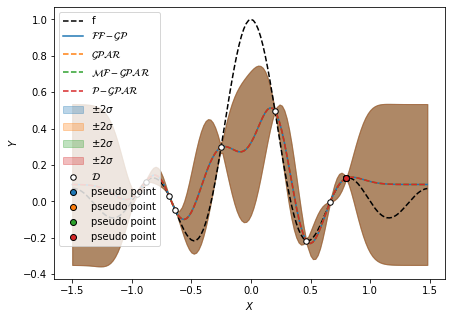

In [8]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

# Ground truth
ax.plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax.plot(x_cont[:, 0], y_pred_ff_gp, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax.fill_between(x_cont.T[0],
                (y_pred_ff_gp + 2 * np.sqrt(var_pred_ff_gp)).T[0],
                (y_pred_ff_gp - 2 * np.sqrt(var_pred_ff_gp)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# GPAR predictions
ax.plot(x_cont[:, 0], y_pred_gpar, color='C1', zorder=-1, label=r'$\mathcal{GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_gpar + 2 * np.sqrt(var_pred_gpar)).T[0],
                (y_pred_gpar - 2 * np.sqrt(var_pred_gpar)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# # # MF-GPAR predictions
ax.plot(x_cont[:, 0], y_pred_mf_gpar, color='C2', zorder=-1, label=r'$\mathcal{MF-GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_mf_gpar + 2 * np.sqrt(var_pred_mf_gpar)).T[0],
                (y_pred_mf_gpar - 2 * np.sqrt(var_pred_mf_gpar)).T[0],
                color='C2',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# PGPAR predictions
ax.plot(x_cont[:, 0], y_pred_pgpar, color='C3', zorder=-1, label=r'$\mathcal{P-GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_pgpar + 2 * np.sqrt(var_pred_pgpar)).T[0],
                (y_pred_pgpar - 2 * np.sqrt(var_pred_pgpar)).T[0],
                color='C3',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# Data points
ax.scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax.scatter(x=pseudo_point[:, 0], y=ff_gp.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=gpar.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=mf_gpar.predict(pseudo_point)[0][0], c='C2', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=pgpar.predict(pseudo_point)[0][0], c='C3', edgecolors='black', label='pseudo point')

ax.legend(loc='upper left')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')

fig.show()

# Test saving

In [30]:
ff_gp_save_path = "models/ff_gp/gp1"

ff_gp.save(ff_gp_save_path)

ff_gp_ = FullyFactorizedGPModel.restore(ff_gp_save_path)

y_pred_ff_gp_, var_pred_ff_gp_ = ff_gp_.predict(x_cont)

y_pred_ff_gp_ = y_pred_ff_gp_.numpy()
var_pred_ff_gp_ = var_pred_ff_gp_.numpy()

gpar_save_path = "models/gpar/gp1"

gpar.save(gpar_save_path)

gpar_ = GPARModel.restore(gpar_save_path)

y_pred_gpar_, var_pred_gpar_ = gpar_.predict(x_cont)

y_pred_gpar_ = y_pred_gpar_.numpy()
var_pred_gpar_ = var_pred_gpar_.numpy()

DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True


DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
 /scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


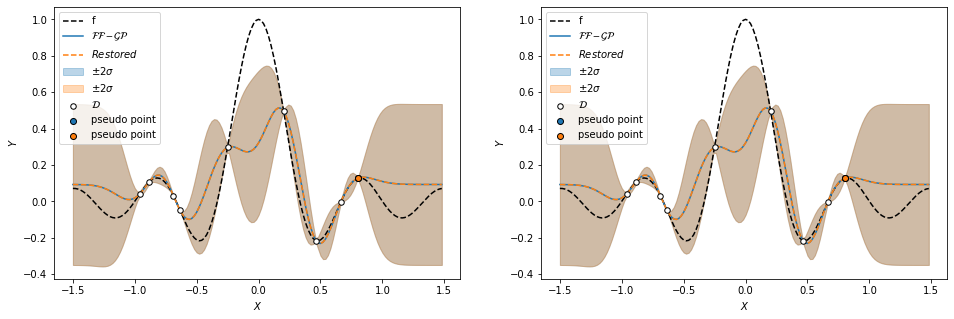

In [31]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Ground truth
ax[0].plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax[0].plot(x_cont[:, 0], y_pred_ff_gp, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax[0].fill_between(x_cont.T[0],
                (y_pred_ff_gp + 2 * np.sqrt(var_pred_ff_gp)).T[0],
                (y_pred_ff_gp - 2 * np.sqrt(var_pred_ff_gp)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# Restored predictions
ax[0].plot(x_cont[:, 0], y_pred_ff_gp_, color='C1', zorder=-1, label=r'$Restored$', linestyle='dashed')
ax[0].fill_between(x_cont.T[0],
                (y_pred_ff_gp_ + 2 * np.sqrt(var_pred_ff_gp_)).T[0],
                (y_pred_ff_gp_ - 2 * np.sqrt(var_pred_ff_gp_)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

ax[0].scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax[0].scatter(x=pseudo_point[:, 0], y=ff_gp.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax[0].scatter(x=pseudo_point[:, 0], y=ff_gp_.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')

ax[0].legend(loc='upper left')
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$Y$')

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

# Ground truth
ax[1].plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax[1].plot(x_cont[:, 0], y_pred_gpar, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax[1].fill_between(x_cont.T[0],
                (y_pred_gpar + 2 * np.sqrt(var_pred_gpar)).T[0],
                (y_pred_gpar - 2 * np.sqrt(var_pred_gpar)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# GPAR predictions
ax[1].plot(x_cont[:, 0], y_pred_gpar_, color='C1', zorder=-1, label=r'$Restored$', linestyle='dashed')
ax[1].fill_between(x_cont.T[0],
                (y_pred_gpar_ + 2 * np.sqrt(var_pred_gpar_)).T[0],
                (y_pred_gpar_ - 2 * np.sqrt(var_pred_gpar_)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

ax[1].scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax[1].scatter(x=pseudo_point[:, 0], y=gpar.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax[1].scatter(x=pseudo_point[:, 0], y=gpar_.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')

ax[1].legend(loc='upper left')
ax[1].set_xlabel('$X$')
ax[1].set_ylabel('$Y$')

fig.show()

# Discrete-kernel GP Test

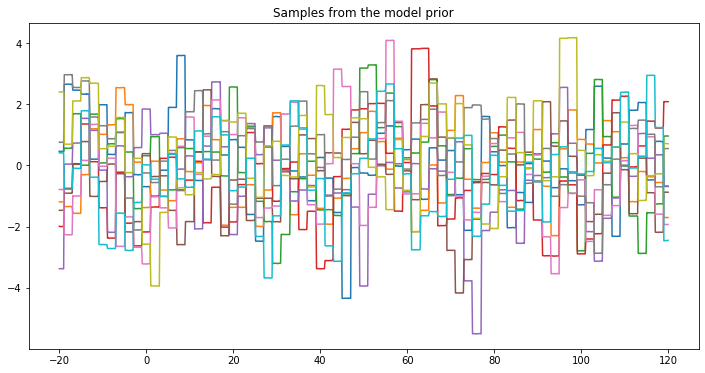

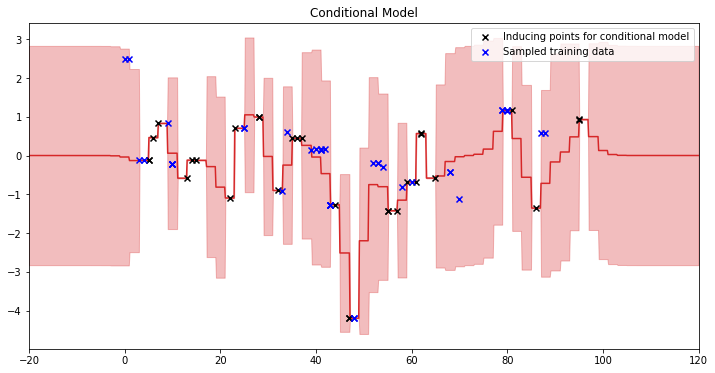

In [195]:
tf.random.set_seed(42)

alpha = 2.
length_scale = 2.
noise = 1e-5

kern = alpha * DiscreteMatern52().stretch(length_scale)
noise_kern = noise * Delta()

signal_gp = GP(kern)
noise_gp = GP(noise_kern)

model = signal_gp + noise_gp

# Generate some data from out model

xs = tf.cast(tf.linspace(-20., 120., 1000), dtype=tf.float32)

plt.figure(figsize=(12, 6))
plt.title("Samples from the model prior")
plt.plot(xs, model(xs).sample(10))
plt.show()

# Pick a random function as our mean
# Random input points
int_xs = tf.random.categorical(logits=5. * tf.random.uniform(shape=(1, 100)),
                               num_samples=30)

int_xs = tf.cast(int_xs, tf.float32)[0]

ys = model(int_xs).sample()[:, 0]

# Condition model on dummy data
cond_model = model | (int_xs, ys)

cond_mean = cond_model(xs).mean.numpy()
cond_var = cond_model.kernel.elwise(xs).numpy()


# Sample from the conditional model
cond_logits = 5. * tf.random.uniform(shape=(1, 100))

# The datapoints we sampled should have 0 probability of being sampled
cond_logits = tf.tensor_scatter_nd_update(cond_logits[0], 
                                          tf.cast(int_xs, tf.int32)[:, None], 
                                          -np.inf * tf.ones_like(int_xs))[None, :]

train_int_xs = tf.random.categorical(logits=cond_logits,
                               num_samples=40)

train_int_xs = tf.cast(train_int_xs, tf.float32)[0]

train_int_ys = cond_model(train_int_xs).sample()

plt.figure(figsize=(12, 6))
plt.title("Conditional Model")
plt.plot(xs, cond_mean, color='C3', zorder=-1,)
plt.fill_between(xs.numpy(),
                (cond_mean + 2 * np.sqrt(cond_var)).T[0],
                (cond_mean - 2 * np.sqrt(cond_var)).T[0],
                color='C3',
                alpha=0.3,
                zorder=-1)
plt.scatter(int_xs, 
            ys,
            marker='x',
            c='k',
            label="Inducing points for conditional model")

plt.scatter(train_int_xs, 
            train_int_ys,
            marker='x',
            c='b',
            label="Sampled training data")
plt.legend()
plt.xlim(-20, 120)
plt.show()